In [2]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score

sns.set()

from biobank_olink.constants import PROJECT_ROOT

In [3]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()
           if p.name.startswith("pred_diagnosis")]
results = pd.DataFrame(chain.from_iterable(results))

panels = results.panel.unique()

agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "num_trials", "best_trial_no", "n_estimators"]}
results.groupby(["years", "lifestyle", "bp", "olink"], dropna=False).agg(**agg_values,
                                                                         count=("model", 'size'))

mean_auc_score  mean_num_trials  \
years lifestyle bp    olink                                    
5     False     False False        0.673430            313.2   
      True      False False        0.709863            307.0   
                True  False        0.713865            307.0   
                      True         0.753195            314.6   
10    False     False False        0.669090            306.4   
      True      False False        0.705777            306.4   
                True  False        0.717012            313.0   
                      True         0.751353            307.0   

                             mean_best_trial_no  mean_n_estimators  count  
years lifestyle bp    olink                                                
5     False     False False               206.0             3594.4      5  
      True      False False               193.0             3526.0      5  
                True  False               256.4             3140.6      5  
                      True                155.2             2919.4      5  
10    False     False False               158.8             2694.4      5  
      True      False False               158.0             3731.2      5  
                True  False               250.2             2026.8      5  
                      True                244.8             3727.6      5

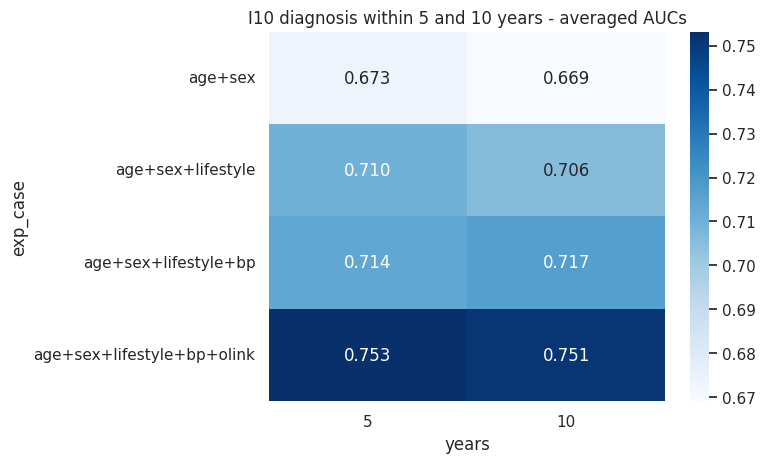

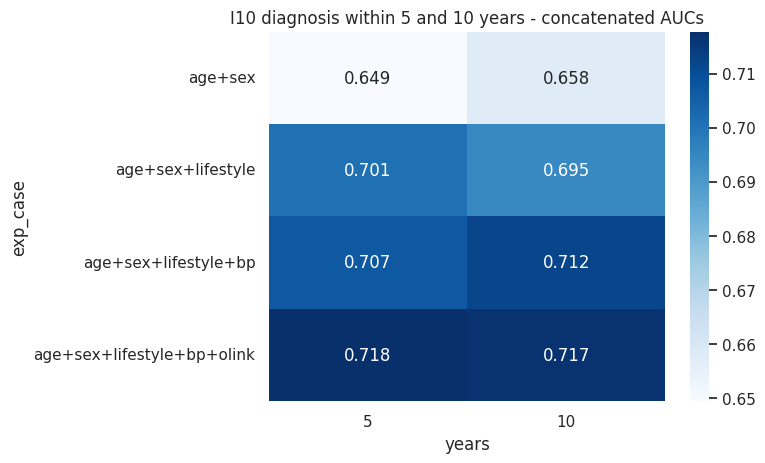

In [5]:
results_aucs = results.groupby(["years", "lifestyle", "bp", "olink"], as_index=False).auc_score.mean()

results_aucs["exp_case"] = results_aucs[["lifestyle", "bp", "olink"]].apply(
    lambda row: "+".join(row.index[row].tolist()), axis=1)
results_aucs["exp_case"] = results_aucs["exp_case"].apply(
    lambda v: "age+sex" + ("+" if v else "") + v)

results_aucs["auc_concat"] = results.groupby(["years", "lifestyle", "bp", "olink"]).apply(
    lambda df: roc_auc_score(np.concatenate(df["y_test"].values),
                             np.concatenate(df["y_proba"].values))).reset_index(drop=True)


results_auc_score = results_aucs.groupby(["exp_case", "years"]).auc_score.mean().unstack("years")
sns.heatmap(data=results_auc_score, annot=True, fmt=".3f", cmap="Blues")
plt.title("I10 diagnosis within 5 and 10 years - averaged AUCs")
plt.show()

results_auc_concat = results_aucs.groupby(["exp_case", "years"]).auc_concat.mean().unstack("years")
sns.heatmap(data=results_auc_concat, annot=True, fmt=".3f", cmap="Blues")
plt.title("I10 diagnosis within 5 and 10 years - concatenated AUCs")
plt.show()